In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## average trajectory plots

In [2]:
d = pd.read_parquet("output/01-single-locus")
d["p"] = d["m_a"] / (2 * d["num_individuals"])
d["gen"] = d["cycle"] - 100
d["freq0"] = d["f0"].apply(lambda x: f"{x:.03}")
d["sExp"] = d["selExp"].apply(lambda x: f"{1.0 + x:.03}")
d["sTrunc"] = d["selTrunc"].apply(lambda x: f"{1.0 + x:.03}")

d = d.sort_values(by=["sExp", "sTrunc"])

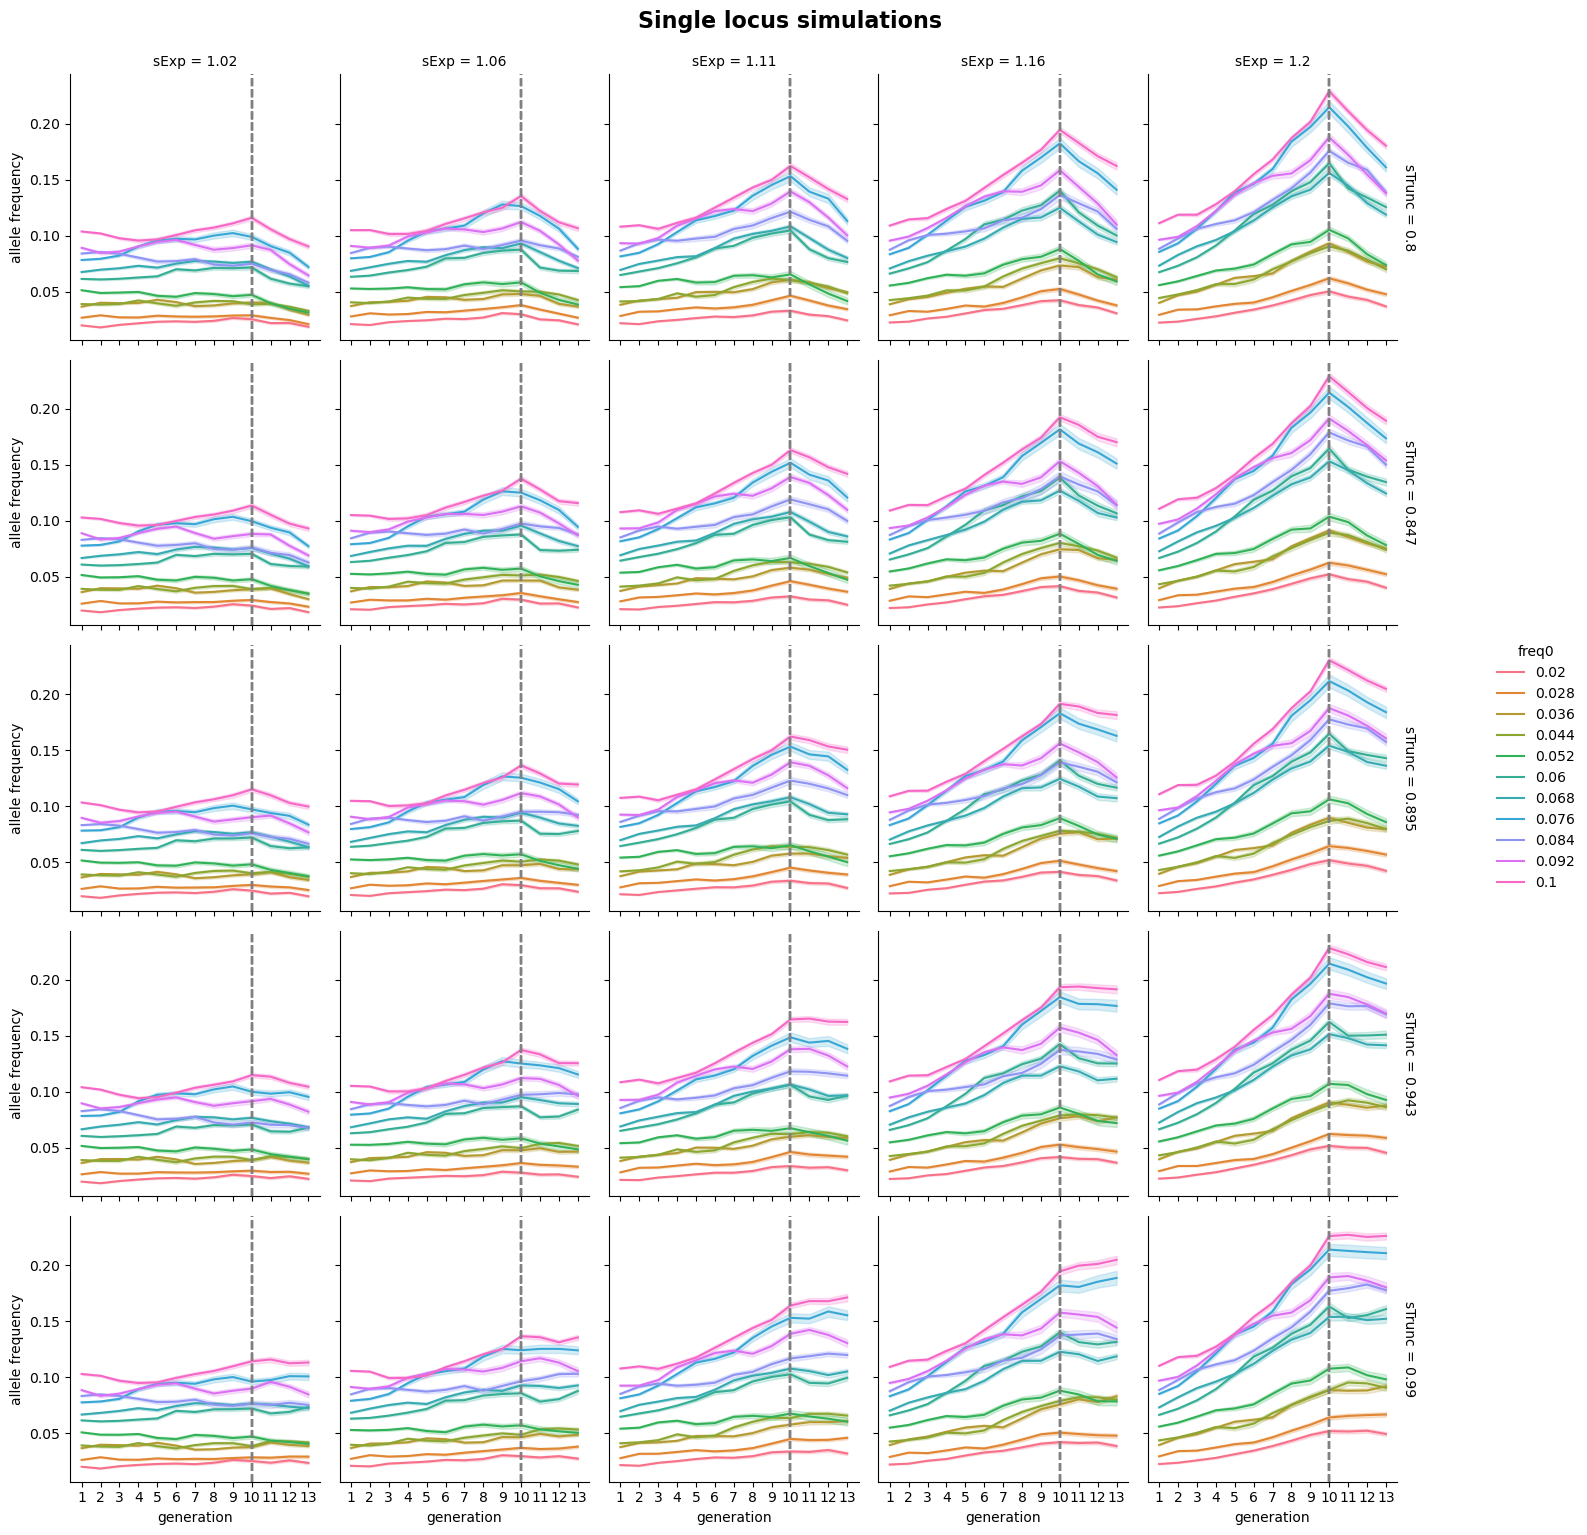

In [3]:
g = sns.FacetGrid(
    d,
    row="sTrunc",
    col="sExp",
    hue="freq0",
    sharex=True,
    sharey=True,
    margin_titles=True,
)

g.map(sns.lineplot, "gen", "p")
g.set_ylabels("allele frequency")
g.set_xlabels("generation")
g.add_legend()
for ax in g.axes.flat:
    ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
g.refline(x=10)
g.figure.suptitle("Single locus simulations", y=1.02, size=16, weight="bold")
g.savefig("single-locus-trajectories.pdf", bbox_inches="tight")

In [ ]:
d = pd.read_parquet("output/03-far-loci").query("f0 == 0.06")
d["pA"] = d["m_a"] / (2 * d["num_individuals"])
d["pB"] = d["m_b"] / (2 * d["num_individuals"])
d["gen"] = d["cycle"] - 99
d["freq0"] = d["f0"].apply(lambda x: f"{x:.03}")
d["sExpA"] = d["selExpA"].apply(lambda x: f"{1.0 + x:.03}")
d["sTruncA"] = d["selTruncA"].apply(lambda x: f"{1.0 + x:.03}")
d["sExpB"] = d["selExpB"].apply(lambda x: f"{1.0 + x:.03}")
d["sTruncB"] = d["selTruncB"].apply(lambda x: f"{1.0 + x:.03}")
d["distance"] = (d["mutPosB"] - d["mutPosA"]).abs()

dm = d.melt(
    id_vars=["replicate", "rsq", "distance", "sExpA", "sTruncB", "gen"],
    value_vars=["pA", "pB"],
    var_name="locus",
    value_name="p",
).sort_values(by=["sExpA", "sTruncB"])

In [ ]:
for rsq in dm["rsq"].unique():
    dplot = dm.query("rsq == @rsq")
    g = sns.FacetGrid(
        dplot,
        row="sTruncB",
        col="sExpA",
        hue="locus",
        sharex=True,
        sharey=True,
        margin_titles=True,
    )

    g.map(sns.lineplot, "gen", "p")
    g.set_ylabels("allele frequency")
    g.set_xlabels("generation")
    g.add_legend()
    for ax in g.axes.flat:
        ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
    g.refline(x=10)
    g.figure.suptitle(
        f"Two loci simulations, $p_0$ = 0.06, distance {dplot.distance.iloc[0] / 1e6}Mb, initial $r^2$ {rsq}",
        y=1.02,
        size=16,
        weight="bold",
    )
    g.savefig(f"two-loci-{dplot.distance.iloc[0] / 1e6}-{rsq}.pdf", bbox_inches="tight")
    plt.close(g.figure)

In [5]:
pd.read_parquet("output/05-close-loci").f0.unique()

array([0.02, 0.04, 0.06, 0.08, 0.1 ])

In [6]:
d = pd.read_parquet("output/05-close-loci").query("f0 == 0.1")
d["pA"] = d["m_a"] / (2 * d["num_individuals"])
d["pB"] = d["m_b"] / (2 * d["num_individuals"])
d["gen"] = d["cycle"] - 2
d["freq0"] = d["f0"].apply(lambda x: f"{x:.03}")
d["sExpA"] = d["selExpA"].apply(lambda x: f"{1.0 + x:.03}")
d["sTruncA"] = d["selTruncA"].apply(lambda x: f"{1.0 + x:.03}")
d["sExpB"] = d["selExpB"].apply(lambda x: f"{1.0 + x:.03}")
d["sTruncB"] = d["selTruncB"].apply(lambda x: f"{1.0 + x:.03}")
d["distance"] = (d["mutPosB"] - d["mutPosA"]).abs()
dm = d.melt(
    id_vars=["replicate", "rsq", "distance", "sExpA", "sTruncB", "gen"],
    value_vars=["pA", "pB"],
    var_name="locus",
    value_name="p",
).sort_values(by=["sExpA", "sTruncB"])
dm["locus"] = dm["locus"].apply(lambda x: x[1])

In [7]:
for distance in dm["distance"].unique():
    for rsq in dm["rsq"].unique():
        dplot = dm.query("rsq == @rsq and distance == @distance")
        g = sns.FacetGrid(
            dplot,
            row="sTruncB",
            col="sExpA",
            hue="locus",
            sharex=True,
            sharey=True,
            margin_titles=True,
        )

        g.map(sns.lineplot, "gen", "p")
        g.set_ylabels("allele frequency")
        g.set_xlabels("generation")
        g.add_legend()
        for ax in g.axes.flat:
            ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
        g.refline(x=10)
        g.figure.suptitle(
            f"Two loci simulations, $p_0$ = 0.06, distance {distance / 1e6}Mb, initial $r^2$ {rsq}",
            y=1.02,
            size=16,
            weight="bold",
        )

        g.savefig(f"two-loci-{distance / 1e6}-{rsq}.pdf", bbox_inches="tight")
        plt.close(g.figure)

## selection coefficient plots

In [107]:
import polars as pl

dfar = pl.scan_parquet("output/03-far-loci")
dclose = pl.scan_parquet("output/05-close-loci")
d = (
    pl.concat([dfar, dclose])
    .filter(pl.col("f0") == 0.06)
    .with_columns(
        (pl.col("m_a") / (2 * pl.col("num_individuals"))).alias("pA"),
        (pl.col("m_b") / (2 * pl.col("num_individuals"))).alias("pB"),
        (pl.col("cycle") - 2).alias("gen"),
        pl.format("{}", pl.col("rsq")).alias("rsq"),
        pl.format("{}", pl.col("f0")).alias("freq0"),
        pl.format("{}", 1 + pl.col("selExpA")).alias("sExpA"),
        pl.format("{}", 1 + pl.col("selExpB")).alias("sExpB"),
        pl.format("{}", 1 + pl.col("selTruncA")).alias("sTruncA"),
        pl.format("{}", 1 + pl.col("selTruncB")).alias("sTruncB"),
        (pl.col("mutPosB") - pl.col("mutPosA")).abs().alias("distance"),
    )
)

ds = (
    d.filter(pl.col("gen") >= 10)
    .with_columns(
        (pl.col("gen") - 10).alias("tgen"),
        pl.col("pA")
        .diff(1)
        .shift(-1)
        .over("sExpA", "sTruncB", "distance", "rsq", "replicate")
        .alias("dpA"),
        pl.col("pB")
        .diff(1)
        .shift(-1)
        .over("sExpA", "sTruncB", "distance", "rsq", "replicate")
        .alias("dpB"),
    )
    .drop_nulls()
    .with_columns(
        (1 + pl.col("dpA") / (pl.col("pA") * (1 - pl.col("pA") - pl.col("dpA")))).alias(
            "sA"
        ),
        (1 + pl.col("dpB") / (pl.col("pB") * (1 - pl.col("pB") - pl.col("dpB")))).alias(
            "sB"
        ),
        ((pl.col("pA") + pl.col("dpA")) / pl.col("pA")).alias("sAdirect"),
        ((pl.col("pB") + pl.col("dpB")) / pl.col("pB")).alias("sBdirect"),
    )
    .collect()
    .sort(["distance", "sExpA", "sTruncB", "rsq", "replicate", "tgen"])
    .to_pandas()
)

In [102]:
for distance in ds["distance"].unique():
    dist = distance / 1e6
    dplot = ds.query("distance == @distance and tgen == 0").melt(
        id_vars=["distance", "sExpA", "sTruncB", "rsq", "replicate", "tgen"],
        value_vars=["sA", "sB"],
        var_name="locus",
        value_name="s",
    )
    dplot["locus"] = dplot["locus"].apply(lambda x: x[1])

    g = sns.FacetGrid(
        dplot, row="sTruncB", col="sExpA", sharex=True, sharey=True, margin_titles=True
    )

    g.map(
        sns.boxplot,
        "rsq",
        "s",
        "locus",
        hue_order=["A", "B"],
        order=sorted(dplot["rsq"].unique()),
        palette=sns.xkcd_palette(["steel", "medium green"]),
        flierprops={"marker": "."},
        fliersize=1,
    )

    g.refline(y=1)

    g.add_legend()
    g.set_ylabels("selection coefficient $s$\nduring truncation")
    g.set_xlabels("initial $r^2$")

    g.figure.suptitle(
        f"Empirical $s$ for the first generation of truncation, distance {distance / 1e6}Mb",
        y=1.02,
        size=16,
        weight="bold",
    )

    g.savefig(f"plots/trunc-selection/gen0-{dist}.pdf", bbox_inches="tight")
    plt.close(g.figure)

In [103]:
for distance in ds["distance"].unique():
    dist = distance / 1e6
    dplot = ds.query("distance == @distance").melt(
        id_vars=["distance", "sExpA", "sTruncB", "rsq", "replicate", "tgen"],
        value_vars=["sA", "sB"],
        var_name="locus",
        value_name="s",
    )

    dplot["locus"] = dplot["locus"].apply(lambda x: x[1])
    dplot = (
        dplot.groupby(["sTruncB", "sExpA", "rsq", "replicate", "locus"])
        .agg({"s": "mean"})
        .reset_index()
    )

    g = sns.FacetGrid(
        dplot, row="sTruncB", col="sExpA", sharex=True, sharey=True, margin_titles=True
    )

    g.map(
        sns.boxplot,
        "rsq",
        "s",
        "locus",
        hue_order=["A", "B"],
        order=sorted(dplot["rsq"].unique()),
        palette=sns.xkcd_palette(["steel", "medium green"]),
        flierprops={"marker": "."},
        fliersize=1,
    )

    g.refline(y=1)

    g.add_legend()
    g.set_ylabels("selection coefficient $s$\nduring truncation")
    g.set_xlabels("initial $r^2$")

    g.figure.suptitle(
        f"Empirical $s$ during truncation, distance {distance / 1e6}Mb",
        y=1.02,
        size=16,
        weight="bold",
    )

    g.savefig(f"plots/trunc-selection/total-{dist}.pdf", bbox_inches="tight")
    plt.close(g.figure)

In [174]:
def plot_ebars(*, data, **kwargs):
    ax = plt.gca()
    palette = sns.xkcd_palette(["medium green", "steel"])
    da = data.query("locus== 'A'")
    db = data.query("locus== 'B'")

    x = da["rsq"]
    y = da[0.5]
    yerr = (y - da[0.025], da[0.975] - y)
    ax.errorbar(x=x, y=y, yerr=yerr, color=palette[0], label="A")

    x = db["rsq"]
    y = db[0.5]
    yerr = (y - db[0.025], db[0.975] - y)
    ax.errorbar(x=x, y=y, yerr=yerr, color=palette[1], label="B")

In [175]:
for distance in ds["distance"].unique():
    dist = distance / 1e6
    dplot = ds.query("distance == @distance").melt(
        id_vars=["distance", "sExpA", "sTruncB", "rsq", "replicate", "tgen"],
        value_vars=["sA", "sB"],
        var_name="locus",
        value_name="s",
    )

    dplot["locus"] = dplot["locus"].apply(lambda x: x[1])
    dplot = (
        dplot.groupby(["distance", "sTruncB", "sExpA", "rsq", "replicate", "locus"])
        .agg({"s": "mean"})
        .reset_index()
    )

    boots = []

    for i in tqdm(range(1000)):
        boots.append(
            dplot.groupby(["distance", "sTruncB", "sExpA", "rsq", "locus"])
            .sample(frac=1, replace=True)
            .groupby(["distance", "sTruncB", "sExpA", "rsq", "locus"])
            .agg({"s": "mean"})
            .reset_index()
        )

    dboot = (
        pd.concat(boots)
        .groupby(["distance", "sTruncB", "sExpA", "rsq", "locus"])["s"]
        .quantile([0.025, 0.5, 0.975])
        .unstack()
        .reset_index()
    )

    g = sns.FacetGrid(
        dboot, row="sTruncB", col="sExpA", sharex=True, sharey=True, margin_titles=True
    )

    g.map_dataframe(plot_ebars)

    # g.map(
    #     sns.boxplot,
    #     "rsq",
    #     "s",
    #     "locus",
    #     hue_order=["A", "B"],
    #     order=sorted(dplot["rsq"].unique()),
    #     palette=sns.xkcd_palette(["steel", "medium green"]),
    #     flierprops={"marker": "."},
    #     fliersize=1,
    # )

    g.refline(y=1)

    g.add_legend()
    g.set_ylabels("selection coefficient $s$\nduring truncation")
    g.set_xlabels("initial $r^2$")

    g.figure.suptitle(
        f"Empirical $s$ during truncation, distance {distance / 1e6}Mb",
        y=1.02,
        size=16,
        weight="bold",
    )

    g.savefig(f"plots/trunc-selection-medians/total-{dist}.pdf", bbox_inches="tight")
    plt.close(g.figure)

100%|██████████| 1000/1000 [00:37<00:00, 26.88it/s]
